In [1]:
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from ipywidgets import interact
import numpy as np

In [2]:
# Penalty Percentage for instant locker drain (80%)
PENALTY_PERCENTAGE = 0.8 

In [3]:
# FLUID Class
class Fluid:
    def __init__(self):
        # Fluid Total Supply (only considering community owned supply - i.e. excluding Treasury, Investors, Team vesting...)
        self.supply = 0

        # Fluid Supply in Lockers
        self.locked = 0

        # Fluid Supply out of Lockers
        self.unlocked = 0


# Locker Class
class Locker:
    def __init__(self):
        # To simplify this model, Locker is a singleton that represents all user's locker
        self.owners = {}

    # Add `amount` of $FLUID to the `recipient` locker 
    def lock_fluid(self, recipient, amount):
        self.owners[recipient] = {
            'amount': amount,
            'staked': 0
        }
    
    # Drain $FLUID from `owner` locker
    def drain_fluid(self, incentiveManager, owner, isInstant):
        if(self.owners[owner]['amount'] == 0):
            return 
            
        if(isInstant):
            drain_penalty = PENALTY_PERCENTAGE * self.owners[owner]['amount']
            IncentiveManager.topup_incentives(incentiveManager, drain_penalty)

        self.owners[owner] = {
            'amount': 0,
            'staked': 0
        }

    def stake_fluid(self, owner):
        if(self.owners[owner]['amount'] == 0):
            return 

        self.owners[owner]['staked'] = self.owners[owner]['amount']

    def aggregate_locked(self):
        return sum(owner_info['amount'] for owner_info in self.owners.values())
    
    def aggregate_staked(self):
        return sum(owner_info['staked'] for owner_info in self.owners.values())


# Incentive Manager Class
class IncentiveManager:
    def __init__(self):
        self.reserve = 0

    def topup_incentives(self, amount):
        self.reserve += amount



    

In [4]:
# Simulation Variables
NUM_OF_RECIPIENT = 15_000
MAX_AMOUNT_AIRDROPPED = 30_000

In [5]:
# Distribute $FLUID to Lockers (BEFORE TTE)
def init_locker(locker):
    for i in range(NUM_OF_RECIPIENT):
        # Generate data
        owner_name = f"owner_{i + 1}"
        lock_amount = random.randint(1, MAX_AMOUNT_AIRDROPPED)  # Random deposit amount
        locker.lock_fluid(owner_name, lock_amount)

In [6]:
# This simulation will randomly chose a locker operation to each user
# Choice of operations are : 0 - instant drain | 1 - vest drain | 2 - stake | 3 - do nothing

def simulate_user_behavior(locker, incentiveManager):
    # Initialize the scenario results
    reserve_over_time = []
    staked_over_time = []
    timestamps = []
    
    # Define start time
    start_time = datetime.today()

    for i in range(NUM_OF_RECIPIENT):
        owner_name = f"owner_{i + 1}"
        operation = random.randint(0, 3)  # Randomly select an operation
        if operation == 0:
            locker.drain_fluid(incentiveManager, owner_name, True)

        elif operation == 1:
            locker.drain_fluid(incentiveManager, owner_name, False)
            
        elif operation == 2:
            locker.stake_fluid(owner_name)

        else:
            continue
    
        # Record the incentives reserve, staked amount and timestamps
        current_time = start_time + timedelta(days=(i * 365 / NUM_OF_RECIPIENT))
        timestamps.append(current_time)
        reserve_over_time.append(incentiveManager.reserve)
        staked_over_time.append(locker.aggregate_staked())

    return timestamps, reserve_over_time, staked_over_time




In [7]:
def plot_output(timestamps, reserve_over_time, staked_over_time):
    plt.figure(figsize=(12, 6))
    plt.plot(timestamps, reserve_over_time, linestyle='-', color='r', label='$FLUID In Reserve Over Time')
    plt.plot(timestamps, staked_over_time, linestyle='-', color='b', label='$FLUID Staked Over Time')
    plt.xlabel('Time (days)')
    plt.ylabel('$FLUID')
    plt.title('$FLUID Staked and In Reserve Over Time')
    plt.grid(True)
    plt.legend()
    plt.show()


def plot_apr(timestamps, reserve_over_time, staked_over_time):
    apr = []

    for i in range(0, len(timestamps)):
        if staked_over_time[i] > 0:
            apr_value = (reserve_over_time[i] / staked_over_time[i]) * 100
        else:
            apr_value = 0

        apr.append(apr_value)
    
    plt.figure(figsize=(12, 6))
    plt.plot(timestamps, apr, linestyle='-', color='g', label='APR')
    plt.xlabel('Time (days)')
    plt.ylabel('Staking APR (%)')
    plt.title('Staking APR Over Time')
    plt.grid(True)
    plt.legend()
    plt.show()


In [8]:
incentiveManager = IncentiveManager()
locker = Locker()

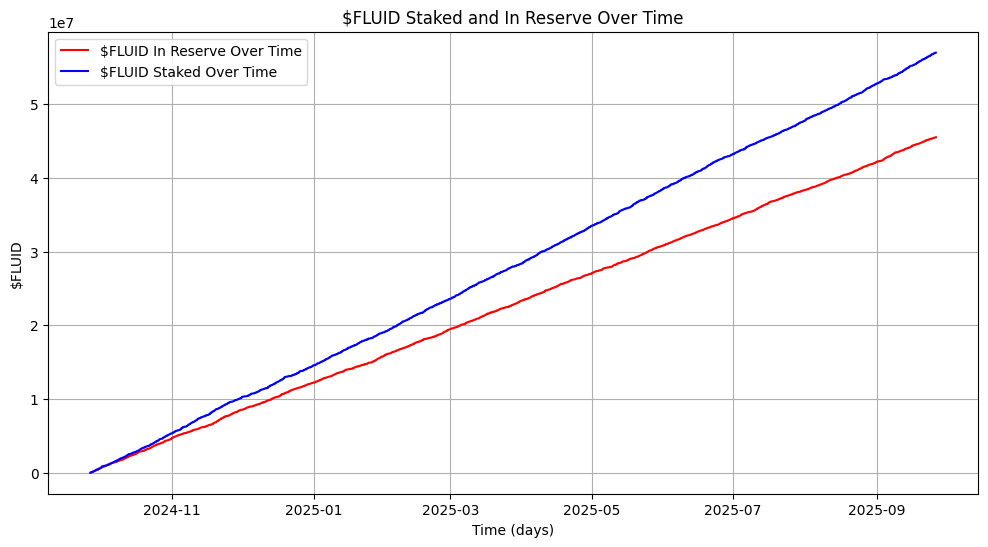

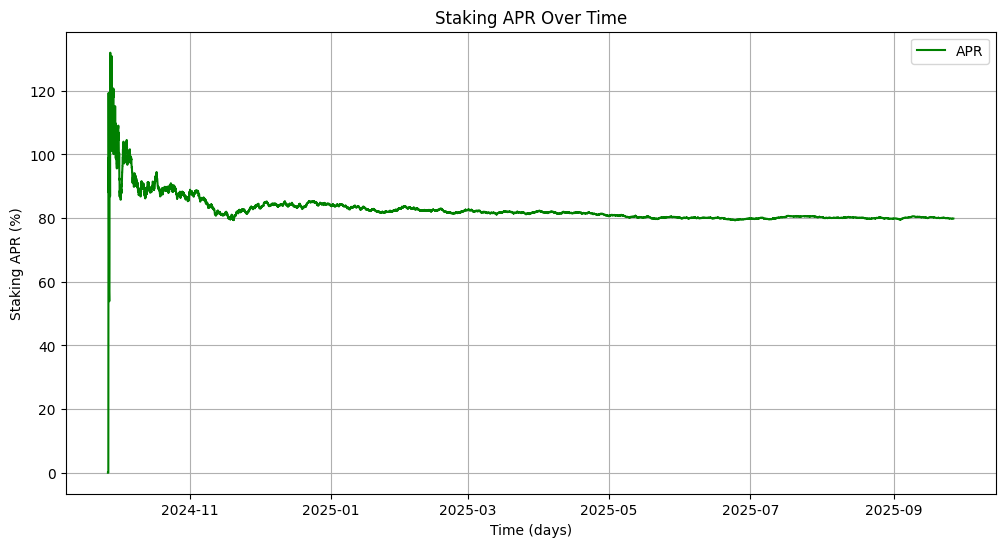

In [9]:
init_locker(locker)


timestamps, reserve_over_time, staked_over_time = simulate_user_behavior(locker, incentiveManager)


plot_output(timestamps, reserve_over_time, staked_over_time)
plot_apr(timestamps, reserve_over_time, staked_over_time)

